In [1]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('..')

from acdc.greaterthan.utils import get_all_greaterthan_things
from ACDCPPExperiment import ACDCPPExperiment
from utils.prune_utils import get_3_caches, split_layers_and_heads
from transformer_lens import HookedTransformer

import numpy as np
import torch as t
import tqdm.notebook as tqdm
import json

import matplotlib.pyplot as plt

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')

/Users/canrager/.pyenv/versions/acdc_env/envs/acdcpp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


# Greaterthan

## Model Setup

In [2]:
model = HookedTransformer.from_pretrained(
    'gpt2-small',
    center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device=device,
)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


## Dataset Setup

In [3]:
# Make clean dataset and reference dataset
N = 25

things = get_all_greaterthan_things(
    num_examples=N, metric_name="greaterthan", device=device
)
greaterthan_metric = things.validation_metric
clean_ds = things.validation_data # clean data x_i
corr_ds = things.validation_patch_data # corrupted data x_i'

print("\nClean dataset samples")
for i in range(5):
    print(model.tokenizer.decode(clean_ds[i]))

print("\nReference dataset samples")
for i in range(5):
    print(model.tokenizer.decode(corr_ds[i]))

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu

Clean dataset samples
The demonstrations lasted from the year 1267 to 12
The assaults lasted from the year 1644 to 16
The affair lasted from the year 1268 to 12
The stature lasted from the year 1653 to 16
The effort lasted from the year 1318 to 13

Reference dataset samples
The demonstrations lasted from the year 1201 to 12
The assaults lasted from the year 1601 to 16
The affair lasted from the year 1201 to 12
The stature lasted from the year 1601 to 16
The effort lasted from the year 1301 to 13


## Show # pruned nodes edges / nodes over threshold

In [4]:
## Calc Node attributions

clean_cache, corrupted_cache, clean_grad_cache = get_3_caches(model, clean_ds, corr_ds, greaterthan_metric, mode="node")
# compute first-order Taylor approximation for each node to get the attribution
clean_head_act = clean_cache.stack_head_results()
corr_head_act = corrupted_cache.stack_head_results()
clean_grad_act = clean_grad_cache.stack_head_results()

# compute attributions of each node
node_attr = (clean_head_act - corr_head_act) * clean_grad_act
# separate layers and heads, sum over d_model (to complete the dot product), batch, and seq
node_attr = split_layers_and_heads(node_attr, model).sum((2, 3, 4)).flatten().abs()

In [5]:
## Calc edge attributions

threshold_dummy = 0.1 # Does not make a difference when only running edge based attribution patching, as all attributions are saved in the result dict anyways
RUN_NAME = 'greaterthan_edge_absval'
acdcpp_exp = ACDCPPExperiment(model,
                              clean_ds,
                              corr_ds,
                              greaterthan_metric,
                              greaterthan_metric,
                              threshold_dummy,
                              run_name=RUN_NAME,
                              verbose=False,
                              attr_absolute_val=True,
                              save_graphs_after=0,
                              pruning_mode="edge",
                              no_pruned_nodes_attr=1
                             )
tlacdc_exp = acdcpp_exp.setup_exp(threshold=threshold_dummy)
attr_results = acdcpp_exp.run_acdcpp(exp=tlacdc_exp, threshold=threshold_dummy)

ln_final.hook_normalized
ln_final.hook_scale
blocks.11.hook_resid_post
blocks.11.hook_mlp_out
blocks.11.mlp.hook_post
blocks.11.mlp.hook_pre
blocks.11.ln2.hook_normalized
blocks.11.ln2.hook_scale
blocks.11.hook_mlp_in
blocks.11.hook_resid_mid
blocks.11.hook_attn_out
blocks.11.attn.hook_result
blocks.11.attn.hook_z
blocks.11.attn.hook_pattern
blocks.11.attn.hook_attn_scores
blocks.11.attn.hook_v
blocks.11.attn.hook_k
blocks.11.attn.hook_q
blocks.11.ln1.hook_normalized
blocks.11.ln1.hook_scale
blocks.11.hook_v_input
blocks.11.hook_k_input
blocks.11.hook_q_input
blocks.11.hook_resid_pre
blocks.10.hook_resid_post
blocks.10.hook_mlp_out
blocks.10.mlp.hook_post
blocks.10.mlp.hook_pre
blocks.10.ln2.hook_normalized
blocks.10.ln2.hook_scale
blocks.10.hook_mlp_in
blocks.10.hook_resid_mid
blocks.10.hook_attn_out
blocks.10.attn.hook_result
blocks.10.attn.hook_z
blocks.10.attn.hook_pattern
blocks.10.attn.hook_attn_scores
blocks.10.attn.hook_v
blocks.10.attn.hook_k
blocks.10.attn.hook_q
blocks.10.ln

KeyboardInterrupt: 

Text(0.5, 1.0, 'Number of remaining edges/nodes after ACDC++ only \n(Greaterthan task, ADCD threshold: 0.01585)')

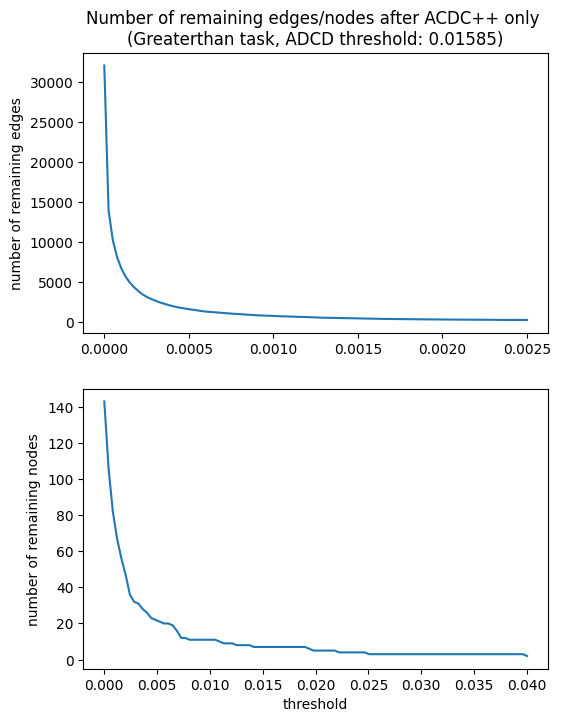

In [17]:
attr_vals = np.array(list(attr_results[1].values()))
thresholds_edge = np.linspace(min(attr_vals), 0.0025, 100)
thresholds_node = np.linspace(min(node_attr), 0.04, 100)
num_edges_above_thresh = np.array(
    [sum(attr_vals > t) for t in thresholds_edge]
)
num_nodes_above_thresh = np.array(
    [sum(node_attr > t) for t in thresholds_node]
)


fig, ax = plt.subplots(2,1, figsize=(6,8))

ax[0].plot(thresholds_edge, num_edges_above_thresh)
ax[1].plot(thresholds_node, num_nodes_above_thresh)
ax[1].set_xlabel("threshold")
ax[0].set_ylabel("number of remaining edges")
ax[1].set_ylabel("number of remaining nodes")
ax[0].set_title("Number of remaining edges/nodes after ACDC++ only \n(Greaterthan task, ADCD threshold: 0.01585)")